In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate, optimize, asarray as ar
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock

from astropy.table import Table
from astropy.io import ascii as ii

matplotlib.rcParams['figure.figsize'] = (12, 7)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


# sys.path.append("/Users/amadeus/Documents/10.semester/ma")
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h
from magmod import sg, powexp, dndz_fit, nofz
from magbias_experiments import LSST
# from lf_photometric import nz_distribution

sigma_8_BBKS = 0.833959881058

#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 
Rescaling the galaxy number density by a factor of 103811.592208 to match the gold sample with 6330073646.61 total galaxies 
#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 



In [2]:
ztab = np.linspace(0.001,4.,200)
rmaxx = 27
# nztab = np.array([nz_distribution(zzz, rmaxx, 'all')[0] for zzz in ztab])
nztab = nofz(ztab, rmaxx)

N = np.trapz(nztab, ztab)
nztab_norm = nztab/N

In [3]:
def gaus(x,mu,si):
    return 1 / (np.sqrt(2*np.pi) * si) *np.exp(-(x-mu)**2/(2*si**2))

def lognorm(x, mu, si):
    return 1 / (x * si * np.sqrt(2*np.pi)) * np.exp(-( np.log(x) - mu)**2/(2*si**2) )

#this moved to magmod:
# def powexp(x, a, zstar, alpha, beta, NORMALIZE = False):
#     res = a * x**alpha * np.exp( -(x / zstar)**beta)
#     if NORMALIZE and type(x)==np.ndarray and len(x) > 10:
#         print "normalizing the output of powexp to integrate to 1"
#         res = res/np.trapz(res,x)
#     return res

def powexpf(x, a, zstar):
    return a * x**2 * np.exp( -x / zstar)

mu0 = 1
si0 = 1
popt,pcov = curve_fit(gaus,ztab,nztab_norm,p0=[mu0,si0])
muopt, siopt = popt


mu0_lono = -0.5
si0_lono = 0.5
popt_lono,pcov_lono = curve_fit(lognorm,ztab,nztab_norm,p0=[mu0_lono,si0_lono])
muopt_lono, siopt_lono = popt_lono

a0 = 1
zstar0 = 1
alpha0 = 1
beta0 = 1
popt_pe, pcov_pe = curve_fit(powexp, ztab, nztab_norm, p0=[a0, zstar0, alpha0, beta0])

ao, zstaro, alphao, betao = popt_pe
print popt_pe


a0f = 1
zstar0f = 1
popt_pe, pcov_pe = curve_fit(powexpf, ztab, nztab_norm, p0=[a0f, zstar0f])
aof, zstarof = popt_pe

print popt_pe

[3.20289342 0.72667614 1.10220826 1.43661841]
[18.2827573   0.30009369]


magmod.py:1009: RuntimeWarning: invalid value encountered in power
  res = a * x**alpha * np.exp( -(x / zstar)**beta)


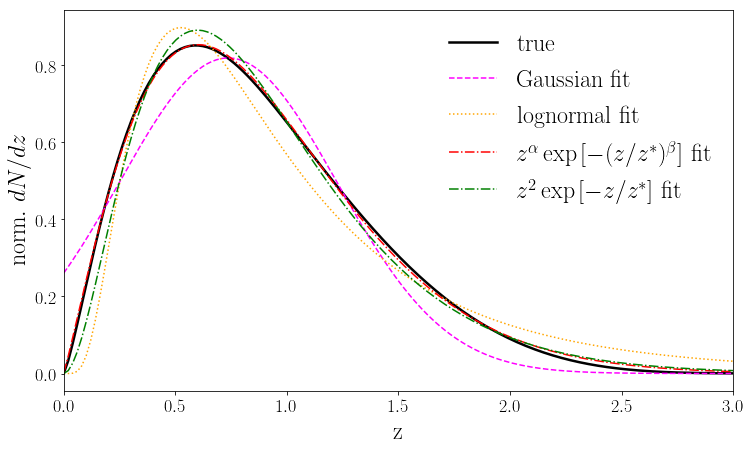

In [4]:
nztab_fit = gaus(ztab, muopt, siopt)
# nztab_fit = nztab_fit / np.trapz(nztab_fit, ztab)

nztab_fit_lono = lognorm(ztab, muopt_lono, siopt_lono)
# nztab_fit_lono = nztab_fit_lono / np.trapz(nztab_fit_lono, ztab)


nztab_fit_pe = powexp(ztab, ao, zstaro, alphao, betao)
# nztab_fit_pe = nztab_fit_pe/np.trapz(nztab_fit_pe, ztab)

nztab_fix_pe = powexpf(ztab, aof, zstarof)
# nztab_fix_pe = nztab_fix_pe/np.trapz(nztab_fix_pe, ztab)


fig = P.figure(figsize = (12,7)); ax= fig.add_subplot(111);
ax.plot(ztab, nztab_norm, c = 'black', lw = 2.5, label = r"$\mathrm{true~}$")
ax.plot(ztab, nztab_fit, c = 'magenta', ls = "--", label = r"$\mathrm{Gaussian ~fit}$")
ax.plot(ztab, nztab_fit_lono, c = 'orange', ls = ":", label = r"$\mathrm{lognormal ~fit}$")
ax.plot(ztab, nztab_fit_pe, c = 'red', ls = "-.", label = r"$z^\alpha \exp{ [ -(z/z^*)^\beta ] }\mathrm{~fit}$")
ax.plot(ztab, nztab_fix_pe, c = 'green', ls = "-.", label = r"$z^2 \exp{[-z/z^*]} \mathrm{~fit}$")

ax.set_xlim((0,3.))

P.legend(frameon = False)

ax.set_ylabel(r"$\mathrm{norm.~}dN/dz$")
ax.set_xlabel("$\mathrm{z}$")
# outdir = "./plots/"

outdir = "/Users/amadeus/Documents/PhD/work/MagBias/plots/"
# P.savefig(outdir + "GaussVSlognorm_fit_dndz.pdf")

In [5]:
#Do we have to normalize the result again, such that the integral is one?
print "integration is {} % off".format((np.trapz(nztab_fit_pe, ztab)-1)*100)

integration is 0.90401032564 % off


Now, fit for all z and m* combinations

In [6]:
#same as for sg, make the dndz table to fit:


ztab = np.linspace(0.0005,4., 1000)
magtab = np.linspace(19,27,500)

# ztab = np.linspace(0.0005,4., 100) #test
# magtab = np.linspace(21,27,50)


# dndztab = np.zeros((len(ztab), len(magtab)))

a0, zstar0, alpha0, beta0 = 3,0.5,1,1.8
popttab = np.zeros((4, len(magtab)))
pcovtab = np.zeros((4,4, len(magtab)))




for im in range(len(magtab)):
#     dndztab = np.array([nz_distribution(zzz, magtab[im], 'all')[0] for zzz in ztab])
    dndztab = nofz(ztab, magtab[im])
    N = np.trapz(dndztab, ztab)
#     dndztab_norm = dndztab/N
    popttab[:,im],pcovtab[:,:,im] = curve_fit(powexp, ztab, dndztab, p0=[N, zstar0, alpha0, beta0])
    

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [7]:
# print popttab[0], "\n",popttab[1], "\n",popttab[2], "\n",popttab[3], "\n",

Text(0,0.5,'$\\sigma_\\beta/\\beta$')

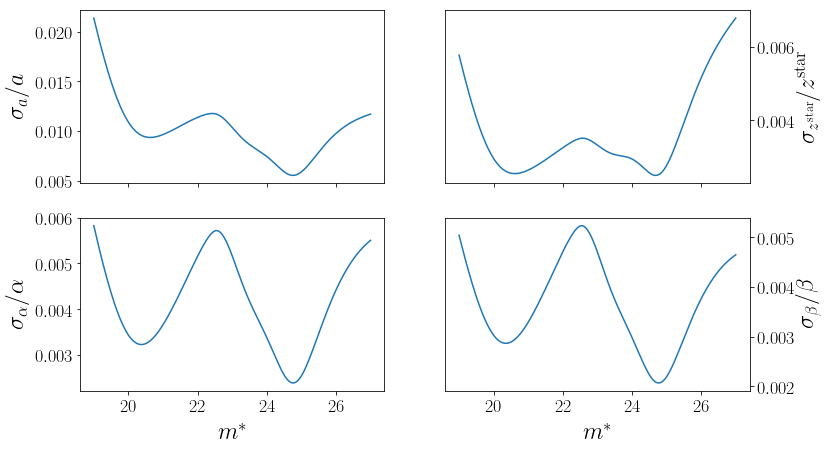

In [8]:
#plot covariances
fig, allax = P.subplots(2, 2, sharex=True)
((ax1, ax2), (ax3, ax4)) = allax

ax1.plot(magtab, np.sqrt(pcovtab[0,0,:])/popttab[0,:])
ax2.plot(magtab, np.sqrt(pcovtab[1,1,:])/popttab[1,:])
ax3.plot(magtab, np.sqrt(pcovtab[2,2,:])/popttab[2,:])
ax4.plot(magtab, np.sqrt(pcovtab[3,3,:])/popttab[3,:])

for axx in allax[1,:]:
    axx.set_xlabel(r"$m^*$")
    
for axx in allax[:,1]:
    axx.yaxis.set_label_position("right")
    axx.yaxis.tick_right()
ax1.set_ylabel(r"$\sigma_a/a$")
ax2.set_ylabel(r"$\sigma_{z^\mathrm{star}}/z^\mathrm{star}$")
ax3.set_ylabel(r"$\sigma_\alpha/\alpha$")
ax4.set_ylabel(r"$\sigma_\beta/\beta$")



test the interpolations!

In [9]:
outnam = "powexp_data/paramtab_for_powexp_in_magmod.txt"
paramnames = ["mstar", "a", "zstar", "alpha", "beta"]
outtab = Table([magtab, popttab[0], popttab[1], popttab[2], popttab[3]], 
               names = paramnames)
# ii.write(outtab, outnam, overwrite=True)

In [10]:
# readtab = ii.read(outnam)


In [11]:
# a0_inter = interp1d(readtab[paramnames[0]], readtab[paramnames[1]], kind = 'cubic', bounds_error = False)
# zstar_inter = interp1d(readtab[paramnames[0]], readtab[paramnames[2]], kind = 'cubic', bounds_error = False)
# alpha_inter = interp1d(readtab[paramnames[0]], readtab[paramnames[3]], kind = 'cubic', bounds_error = False)
# beta_inter = interp1d(readtab[paramnames[0]], readtab[paramnames[4]], kind = 'cubic', bounds_error = False)

# def allparams(mstar):
#     return a0_inter(mstar), zstar_inter(mstar), alpha_inter(mstar), beta_inter(mstar)

time to plot fit = 0.00340599999981 sec
time to plot true = 5.024877 sec
speedup = 1475.3015268 times 

time to plot fit = 0.00202499999978 sec
time to plot true = 6.34789 sec
speedup = 3134.76049417 times 

time to plot fit = 0.00201300000026 sec
time to plot true = 9.993949 sec
speedup = 4964.70392385 times 

time to plot fit = 0.00205300000016 sec
time to plot true = 10.401964 sec
speedup = 5066.71407657 times 

time to plot fit = 0.00206500000058 sec
time to plot true = 10.805484 sec
speedup = 5232.67990167 times 

time to plot fit = 0.00205000000005 sec
time to plot true = 11.463073 sec
speedup = 5591.74292668 times 

time to plot fit = 0.00201100000049 sec
time to plot true = 12.109976 sec
speedup = 6021.86772602 times 



Text(0,0.5,'$dn/dz$')

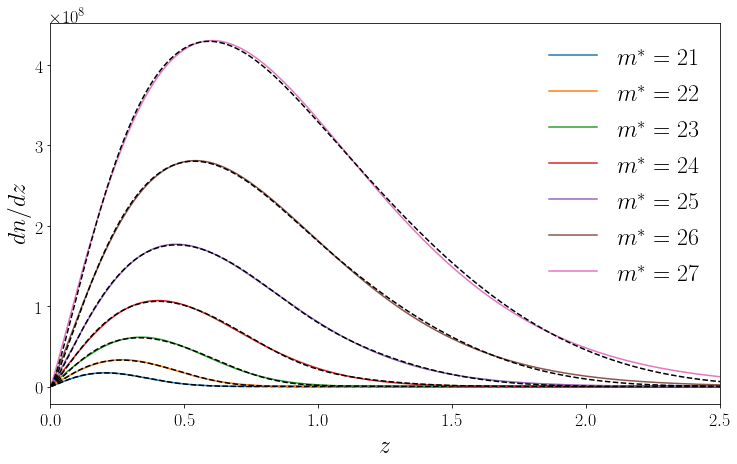

In [12]:
# mtab_coarse = np.linspace(23,27,6)
mtab_coarse = np.arange(21,28)

ztab = np.linspace(0.0005,4., 1000)

fig = P.figure(figsize = (12,7)); ax= fig.add_subplot(111);

for mm in mtab_coarse:
#     aa, zzstar, alal, betbet = allparams(mm)
#     ax.plot(ztab, powexp(ztab, aa, zzstar, alal, betbet, NORMALIZE = True), label = r"$m^* = {}$".format(mm))
    tstart = clock()
    ax.plot(ztab, dndz_fit(ztab, mm), label = r"$m^* = {}$".format(mm))
    tfit =clock() - tstart
    print "time to plot fit = {} sec".format(tfit)
    tstart = clock()
#     nztab = np.array([nz_distribution(zzz, mm, "all")[0] for zzz in ztab])
    nztab = nofz(ztab, mm)
#     N = np.trapz(nztab, ztab)
#     nztab /= N
    ax.plot(ztab, nztab, c = "black", ls = "--")
    ttrue = clock() - tstart
    print "time to plot true = {} sec".format(ttrue)
    print "speedup = {} times \n".format(ttrue/tfit)
ax.set_xlim((0,2.5))
P.legend(loc = "upper right", frameon = False)
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$dn/dz$")
# P.savefig(outdir + "dndz_fit_for_different_mag.pdf")